In [1]:
import os
import torch
import numpy as np

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from config import root_dir

In [2]:
# leave_out = 'sub_out'
leave_out = 'run_out'

# Load Data

In [3]:
# Load spatial encoding
spatial_train = torch.load(os.path.join(root_dir, 'spatial', 'feat', f'{leave_out}_train.pt'))
spatial_test = torch.load(os.path.join(root_dir, 'spatial', 'feat', f'{leave_out}_test.pt'))

spatial_train_X, train_y = spatial_train['features'], spatial_train['label']
spatial_test_X, test_y = spatial_test['features'], spatial_test['label']

In [5]:
# Load temporal features
# rois = ['HG', 'aSTG', 'pSTG']
rois = ['HG']

temporal_train_X = []
temporal_test_X = []

for roi in rois:
    result_dir = os.path.join(root_dir, 'temporal', leave_out, roi)
    train_feat_fname = os.path.join(result_dir, 'train_feat.npy')
    test_feat_fname = os.path.join(result_dir, 'test_feat.npy')
    train_feat = np.load(train_feat_fname)
    test_feat = np.load(test_feat_fname)
    
    temporal_train_X.append(train_feat)
    temporal_test_X.append(test_feat)
    
temporal_train_X = np.concatenate(temporal_train_X, axis=1)
temporal_test_X = np.concatenate(temporal_test_X, axis=1)

train_X = np.concatenate([temporal_train_X, spatial_train_X], axis=1)
test_X = np.concatenate([temporal_test_X, spatial_test_X], axis=1)

pca = PCA()
pca.fit(temporal_train_X)
n = np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]

pca = PCA(n_components=n)

pca_temporal_train_X = pca.fit_transform(temporal_train_X)
pca_temporal_test_X = pca.transform(temporal_test_X)

pca_train_X = np.concatenate([pca_temporal_train_X, spatial_train_X], axis=1)
pca_test_X = np.concatenate([pca_temporal_test_X, spatial_test_X], axis=1)

# SVM

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [217]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(train_X, train_y)

pred_y = clf.predict(test_X)
np.sum(pred_y == test_y)/len(test_y)

0.5257142857142857

In [218]:
pca_clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
pca_clf.fit(pca_train_X, train_y)
pca_pred_y = pca_clf.predict(pca_test_X)
np.sum(pca_pred_y == test_y)/len(test_y)

0.6171428571428571

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [8]:
rf_clf = RandomForestClassifier(max_depth=30, random_state=0)
rf_clf.fit(train_X, train_y)

rf_pred_y = rf_clf.predict(test_X)
np.sum(rf_pred_y == test_y)/len(test_y)

0.72

In [88]:
pca_rf_clf = RandomForestClassifier(max_depth=30, random_state=0)
pca_rf_clf.fit(pca_train_X, train_y)

pca_rf_pred_y = pca_rf_clf.predict(pca_test_X)
np.sum(pca_rf_pred_y == test_y)/len(test_y)

0.702

# KNN

In [90]:
from sklearn.neighbors import KNeighborsClassifier

In [223]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_X, train_y)

knn_pred_y = neigh.predict(test_X)
np.sum(knn_pred_y == test_y)/len(test_y)

0.72

# Naive Bayes

In [105]:
from sklearn.naive_bayes import GaussianNB

In [224]:
gnb = GaussianNB()
nb_y_pred = gnb.fit(train_X, train_y).predict(test_X)
np.sum(nb_y_pred == test_y)/len(test_y)

0.5671428571428572

# Logistic Regression

In [95]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [226]:
lr_clf = LogisticRegression(random_state=0, max_iter=600).fit(train_X, train_y)
lr_pred_y = clf.predict(test_X)
np.sum(lr_pred_y == test_y)/len(test_y)

0.5257142857142857

# CF

In [227]:
cf_svm = confusion_matrix(test_y, pred_y, normalize='true')
cf_rf = confusion_matrix(rf_pred_y, test_y, normalize='true')
knn_cf = confusion_matrix(knn_pred_y, test_y, normalize='true')
nb_cf = confusion_matrix(nb_y_pred, test_y, normalize='true')
lr_cf = confusion_matrix(lr_pred_y, test_y, normalize='true')

In [20]:
cf_rf = confusion_matrix(rf_pred_y, test_y, normalize='true')

In [21]:
np.save('run_out_cf.npy', cf_rf)

# Significance Test

In [32]:
from scipy import stats

rf_acc = []
for i in tqdm(range(500)):
    rf_clf = RandomForestClassifier(max_depth=30, random_state=i)
    rf_clf.fit(train_X, train_y)

    rf_pred_y = rf_clf.predict(test_X)
    rf_acc += [np.sum(rf_pred_y == test_y)/len(test_y)]

100%|██████████| 500/500 [23:12<00:00,  2.78s/it]


In [33]:
spatial_rf_acc = []
for i in tqdm(range(500)):
    spatial_rf_clf = RandomForestClassifier(max_depth=30, random_state=i)
    spatial_rf_clf.fit(spatial_train_X, train_y)

    spatial_rf_pred_y = spatial_rf_clf.predict(spatial_test_X)
    spatial_rf_acc += [np.sum(spatial_rf_pred_y == test_y)/len(test_y)]

100%|██████████| 500/500 [07:26<00:00,  1.12it/s]


In [29]:
stats.ttest_ind(rf_acc, spatial_rf_acc)

Ttest_indResult(statistic=7.422610503288645, pvalue=3.3221258228309326e-12)

# Plot CF

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

In [165]:
cfs = [cf_rf, cf_svm, knn_cf, lr_cf, nb_cf]
labels = ['ambient','symphonic', 'metal', 'rocknroll', 'country']
Method = ['Random Forest', 'Linear SVM', 'K-NN', 'Logistic Regression', 'Naive Bayes']

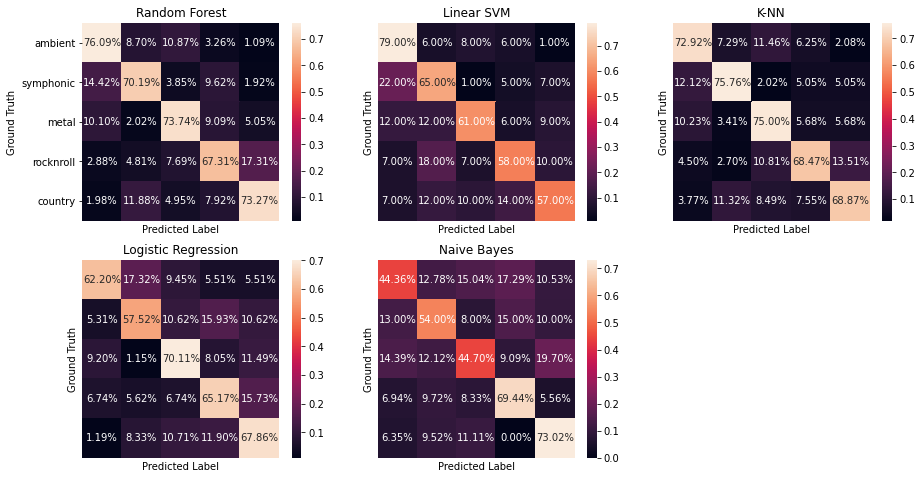

In [228]:
n_row, n_col = 2, 3

fig, axs = plt.subplots(squeeze=False, figsize=(15, 8))
fig.subplots_adjust(hspace=.2)
for i, cf in enumerate(cfs):
    rp, cp = i//n_col, i%n_col
    ax = plt.subplot2grid((2, 3), (rp, cp))
    if i == 0:
        sns.heatmap(cf, ax=ax, yticklabels=labels, xticklabels=[], annot=True, fmt='.2%')
    else:
        sns.heatmap(cf, ax=ax, yticklabels=[], xticklabels=[], annot=True, fmt='.2%')
    ax.set(xlabel='Predicted Label', ylabel='Ground Truth')
    ax.title.set_text(Method[i])
plt.show()